In [1]:
import time
import math
import argparse

import numpy as np

from swarm import Swarm

#TODO: add constraints to drone position

In [2]:
#ArgParser:
parser = argparse.ArgumentParser(description="Example script with argparse")

parser.add_argument('--outputFile', type=str,default='../data/logs/defaultLogfile', help='Path where the output should be stored')
parser.add_argument('--numDrones', type=int, default=10, help='Number of Drones used')

parser.add_argument('--popSize', type=int, default=5, help='Population Size of each Generation')
parser.add_argument('--numGenerations', type=int, default=10, help='Number of Generations')
parser.add_argument('--worldFile', type=str, default='world250Forest', help='name of the world file without sdf')
parser.add_argument('--maxRuns', type=int, default=50, help='maximum number of runs')

args, unknown = parser.parse_known_args()

In [ ]:
#Starts the simulation as a separate thread

import time, select
from subprocess import Popen,PIPE,run
import subprocess
  
process = Popen(['gz','sim', f"../worlds/{args.worldFile}.sdf", '-r','-s'], stdout=PIPE, stderr=PIPE, text=True)



In [3]:
NUM_DRONES = args.numDrones

AREA_SIZE_X = 250
AREA_SIZE_Y = 250
GRID_SIZE = 250       # Size of the Forest

CAMERA_FOV_DEGREE = 50
IMAGE_SIZE = 512 #How many Scanning points each image has per Row (Images are 512x512)

DRONE_HEIGHT = 35

POPULATION_SIZE = args.popSize
NUM_GENERATIONS = args.numGenerations
MUTATION_RATE = 0.1

maxRuns = args.maxRuns

grid_offset=GRID_SIZE/2

camera_fov=np.deg2rad(CAMERA_FOV_DEGREE)
camera_offset= 35 * np.tan(camera_fov/2)

prob_array_size= int(np.ceil((GRID_SIZE*512)/(camera_offset*2)))


#each "Step" is 10 seconds in this Example

#How far the drones should move each step at maximum
DRONE_STEPSIZE= 30
#
#How far the target could move each stepsize (Sigma+=Stepsize)
TARGET_STEPSIZE= 14

#How many Drones should see the same points for it to count as "seen"
seenPercentage = 0.2

start = time.time()

In [4]:
def getProbabilityGrid(Last_Known_Position, sigma):
    #Create Target Probability Grid
    x = np.linspace(-grid_offset, grid_offset, prob_array_size)
    y = np.linspace(-grid_offset, grid_offset, prob_array_size)
    x, y = np.meshgrid(x, y)

    prob_density = (1 / (np.sqrt(2 * np.pi)* sigma)) * np.exp(-((x - Last_Known_Position[0])**2 + (y - Last_Known_Position[1])**2) / (2 * sigma**2))

    return prob_density,x,y

In [5]:
#Spawn Drones and move to initial position

# Create the swarm object by passing the name
# of the world from the .sdf world file.
swarm = Swarm(args.worldFile)

Subscribed successfully


In [6]:


# Spawn X drones and keep the returning ids as handles
#ids = swarm.spawn(NUM_DRONES)
print(f"Trying to spawn {NUM_DRONES*POPULATION_SIZE} Drones")
tries = 0
notStarted = True
ids = 0
while notStarted and tries<15:
    try:
        ids = swarm.spawn(NUM_DRONES*POPULATION_SIZE)
        notStarted = False
        #print(ids)
    except Exception as e:
        print(f"Sim not ready after {tries} minutes, sleeping for 1 minute")
        print(e)
        time.sleep(60)
        tries = tries+1
if tries>=15:
    raise Exception("Simulation couldnt be started after 15 minutes")
    
print("Drones Spawned Sucessfully")

#Initialize Target Position
Target_Position =np.array([25,25])
Last_Known_Position = Target_Position

# First waypoints
waypoints = np.empty((0,3),float)
for i in range (NUM_DRONES):
    waypoints= np.append(waypoints,np.array([[math.ceil(i-(NUM_DRONES/2)),0.0,DRONE_HEIGHT]]), axis=0)

#create Initial
#swarm.waypoints(ids, waypoints)

#Create Target Probability Grid
sigma= 10

prob_density,x,y = getProbabilityGrid(Last_Known_Position,sigma)

#print(prob_density)


Trying to spawn 50 Drones
Drones Spawned Sucessfully


In [7]:
# Problem classes
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

# Algorithmss
from pymoo.algorithms.soo.nonconvex.de import DE

# Survival operators
from pymoo.operators.sampling.lhs import LHS

In [8]:
#return percentage of ground visible (depth>34meter)
def check_ground_visibility(depth_image):
    number_visible_ground=0
    for i in depth_image:
        for j in i:
            if j[0]>3400:
                number_visible_ground= number_visible_ground+1
    return number_visible_ground/(512**2)
 
def update_Target_Position():
    if Target_Position[0]<25:
        Target_Position = Target_Position + [0.5,0.5]


#Gives Coordinates based on drone position and scan pixel
def calculate_world_coordinates(drone_pos, image_radius, img_x, img_y):
    pos_x = drone_pos[0] + (img_x-256)/512 * image_radius * 2
    pos_y = drone_pos[1] + (img_y-256)/512 * image_radius * 2
    return (pos_x, pos_y)

In [9]:
def getOverlapArray(waypoints,offset,img_width=512,img_height=512):
    
    MinX = [0,float('inf')]
    MaxX = [0,float('-inf')]
    MinY = [0,float('inf')]
    MaxY = [0,float('-inf')]
    
    for i in range(len(waypoints)):
        x = waypoints[i][0]
        y = waypoints[i][1]
        #Determine the Minimum X,Y and Maximum X,Y of the sampling positions and saves which drone
        if (x < MinX[1]):
            MinX = [i, x]
        if (x > MaxX[1]):
            MaxX = [i, x]
        if (y < MinY[1]):
            MinY = [i, y]
        if (y > MaxY[1]):
            MaxY = [i, y]
    
    MinX[1] = calculate_world_coordinates(waypoints[MinX[0]], camera_offset, 0,0)[0]
    MaxX[1] = calculate_world_coordinates(waypoints[MaxX[0]], camera_offset, img_width,img_height)[0]
    MinY[1] = calculate_world_coordinates(waypoints[MinY[0]], camera_offset, 0,0)[1]
    MaxY[1] = calculate_world_coordinates(waypoints[MaxY[0]], camera_offset, img_width, img_height)[1]  
    
    #gets the needed width/height of the array based on the distance between smallest and largest X/Y Value, rounding up
    array_width = int(np.ceil(((MaxX[1]-MinX[1])*img_width)/(camera_offset*2)))
    array_height = int(np.ceil(((MaxY[1]-MinY[1])*img_height)/(camera_offset*2)))

    #fills the array with zeroes
    visibility_array = np.zeros((int(array_width), (int(array_height))))
    
    visibility_threshold= 3400 #once depth is higher than this value, the ground counts as seen
    
    #adds 1/NUM_DRONES if the point is seen
    #print(ids[0])
    firstID = ids[0]
    
    for id in range(len(waypoints)):       
        for i in range(img_width):
            for j in range(img_height):
                #print(f"ID: {id+(offset*NUM_DRONES)}     value: {swarm.depth_images[id+(offset*NUM_DRONES)][i][j][0]} ")
                if swarm.depth_images[firstID+id+(offset*NUM_DRONES)][i][j][0] > visibility_threshold:
                    world_x, world_y = calculate_world_coordinates(waypoints[id], camera_offset, j, i)
                    try:
                        world_x_idx = int(((world_x - MinX[1]) / (MaxX[1] - MinX[1])) * array_width)
                        world_y_idx = int(((world_y - MinY[1]) / (MaxY[1] - MinY[1])) * array_height)
                    except Exception as e:
                        print(f"Something went wrong, Exception: {e}\ncurrent coordiantes: world_x: {world_x}, world_y: {world_y}")
                        
                    
                    if 0 <= world_x_idx < array_width and 0 <= world_y_idx < array_height:
                        visibility_array[world_x_idx][world_y_idx] += 1/NUM_DRONES


    visibility_offset_x=int(((MinX[1]+grid_offset)/GRID_SIZE)*prob_array_size)
    visibility_offset_y=int(((MinY[1]+grid_offset)/GRID_SIZE)*prob_array_size)
    
    visibility_offset=[visibility_offset_x,visibility_offset_y]
    
    #get X/Y of target
    target_x_idx = int(((Target_Position[0] - MinX[1]) / (MaxX[1] - MinX[1])) * array_width)
    target_y_idx = int(((Target_Position[1] - MinY[1]) / (MaxY[1] - MinY[1])) * array_height)
    
    targetXY= [target_x_idx,target_y_idx]
    
    #print(f"target is at [{Target_Position}], corresponding to {targetXY}, in the array of size [{array_width},{array_height}]")
    
    return visibility_array, visibility_offset, targetXY
    


In [10]:
def scoreThatThing(prob_density,visibility_grid,visibility_offset, targetXY):
    
    #print("Scoring somthing")
    
    scoringArray=np.zeros(prob_density.shape)
    score=0
    targetSeen = False
    #print("Visibility grid in scoring: ", visibility_grid.shape)
    for i in range(visibility_grid.shape[0]):
        for j in range(visibility_grid.shape[1]):
            visibility_Value=visibility_grid[i][j]
        
            #only add score if half the drones see square
            if visibility_Value>=seenPercentage:
                tileScore = prob_density[i+visibility_offset[0]][j+visibility_offset[1]]*visibility_Value
                if i-3<=targetXY[0]<=i+3 and j-3<=targetXY[1]<=j+3:
                    targetSeen=True
                    #print("Saw somehting!")
                    score+=(tileScore*5)
                    scoringArray[i][j]=tileScore*5
                else:
                    score+=tileScore
                    scoringArray[i][j]=tileScore
                
    #plt.imshow(scoring_array, cmap='gray')
    #plt.show()
    return score, targetSeen,scoringArray

In [11]:
evalTimings= []
overlapTimings = []
scoringTimings = [] 
waypointTimings = []

class MyProblem(Problem):

    def __init__(self, grid_size, n_drones, n_steps,waypoints,prob_density):
        
        self.grid_size = grid_size
        self.n_drones = n_drones
        n_var=2*n_drones
        self.n_steps = n_steps
        
        self.waypoints = waypoints
        self.prob_density = prob_density
        
        super().__init__(
            n_var=n_var,  # Variables in the solutions (x,y)
            n_obj=1,      # Number of Objectives we wanna optimize
            n_constr=0,   # No additional constraints, TODO: add no crashing into eachother
            xl=0,      # Lower boundaries of solution variables
            xu=1,       # Upper bounds of solution vars
        )    

        #x are the waypoints
    def _evaluate(self, x, out, *args, **kwargs):
        
        evalTime_start = time.time()
        
        scores = np.zeros(POPULATION_SIZE)
        seenAr = np.zeros(POPULATION_SIZE)
        visibilityAr = []
        scoringAr = []
        #scales the variables to  [-2,2]
        _x= np.array(x)*4-2
        #reshapes the variables back into a waypoint array
        coordinates = _x.reshape(-1, 2)        
        
        #adds a 0 for height to the coordinates
        padded_coordiantes = np.pad(coordinates,((0, 0), (0, 1)),mode='constant',constant_values=0)
        
        #tiles the waypoints and adds the moves, then sends all waypoints(NUM_DRONES*POPULATION_SIZE) to the simulation
        tempWaypoints = np.tile(waypoints,(POPULATION_SIZE,1)) + padded_coordiantes
        swarm.waypoints(ids,tempWaypoints)
        
        isScored = False
        score = None
        
        waypoint_start = time.time()
        #print(ids)
        while not isScored:
            #wait until all drones received
            
            if swarm.received_frames[ids[-1]]:
                waypointTimings.append(time.time()-waypoint_start)
                #print(f"Frames received after {time.time()-evalTime_start} seconds")
                for i in range(POPULATION_SIZE):
                    solutionWaypoints = tempWaypoints[i*NUM_DRONES:(i+1)*NUM_DRONES]
                    
                    #time start
                    overlap_start = time.time()
                    visibility_grid,visibility_offset, targetXY = getOverlapArray(solutionWaypoints,offset=i)
                    overlapTimings.append(time.time()-overlap_start)
                    
                    scoring_start = time.time()
                    score, _wasSeen,scoringArray = scoreThatThing(self.prob_density,visibility_grid,visibility_offset,targetXY)
                    scoringTimings.append(time.time()-scoring_start)
                    #print time
                    
                    scores[i] = -score
                    seenAr[i] = _wasSeen
                    #print(f"Waypoints: {solutionWaypoints}")
                    #print(visibility_grid)
                    visibilityAr.append(copy.deepcopy(visibility_grid))
                    scoringAr.append(copy.deepcopy(scoringArray))
                    #print(visibilityAr)
                
                #print(f"finished scoring {time.time()-evalTime_start} seconds after starting evaluation")
                isScored=True
        
        out["F"] = scores
        out["aux1"] = seenAr
        out["aux2"] = visibilityAr
        out["aux3"] = scoringAr
        
        evalTimings.append(time.time()-evalTime_start)   
        #print(f"the average evaluation time per generation was {np.mean(evalTimings)} seconds")
        #print(f"the average waypointTimings was {np.mean(waypointTimings)} seconds")
        #print(f"the average overlapTimings per Solution Individual was {np.mean(overlapTimings)} seconds")
        #print(f"the average scoringTimings per Solution Individual was {np.mean(scoringTimings)} seconds")
        

In [12]:
from pymoo.core.sampling import Sampling
class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        X = [np.random.rand(problem.n_var)]
        #X = np.array(0)
        for i in range(n_samples-1):
            X= np.append(X,[np.random.rand(problem.n_var)], axis=0)
        return X
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", NUM_GENERATIONS)

In [13]:
problem = MyProblem(GRID_SIZE, NUM_DRONES, NUM_GENERATIONS, waypoints, prob_density)

algorithm = DE(
    pop_size=POPULATION_SIZE,
    sampling=MySampling(),    #Für initiale Population
    variant="DE/rand/1/bin",
    CR=0.9,
    F=0.8,
    dither="vector"
)

In [14]:
import matplotlib.pyplot as plt
import copy

Starting now, at 2.8983216285705566


/home/user/.local/lib/python3.7/site-packages/pymoo/core/problem.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  v = np.array(v)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        5 | -7.885924E+01 | -8.804274E+01
     2 |       10 | -8.212743E+01 | -8.804274E+01


/home/user/.local/lib/python3.7/site-packages/pymoo/core/problem.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  v = np.array(v)


     3 |       15 | -8.996902E+01 | -9.825135E+01
     4 |       20 | -9.211689E+01 | -9.825135E+01
     5 |       25 | -9.517853E+01 | -9.949780E+01
     6 |       30 | -9.726785E+01 | -9.949780E+01
     7 |       35 | -9.778157E+01 | -9.949780E+01
     8 |       40 | -9.848028E+01 | -9.949780E+01
     9 |       45 | -9.854276E+01 | -9.949780E+01
    10 |       50 | -9.922433E+01 | -9.974718E+01
New Position: 
[[ 22.32837614  29.29526141  35.        ]
 [-28.95083558  19.70635857  35.        ]
 [ 22.14043142  19.45226158  35.        ]
 [-15.14690614  -7.74814763  35.        ]
 [-20.68930794  27.10657291  35.        ]
 [-28.95833173  28.05226774  35.        ]
 [ 20.72604465 -24.01862511  35.        ]
 [ 18.01965031  13.6683442   35.        ]
 [ -2.77271113  10.42775064  35.        ]
 [  0.4269089   14.81938114  35.        ]]

Visibility Grid of Best solution: 




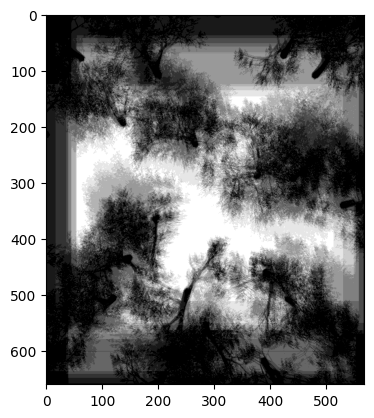

Scoring Grid of Best solution: 




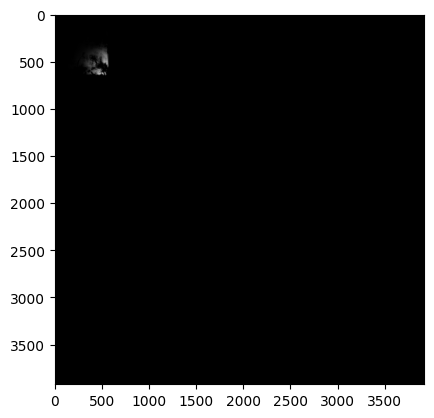

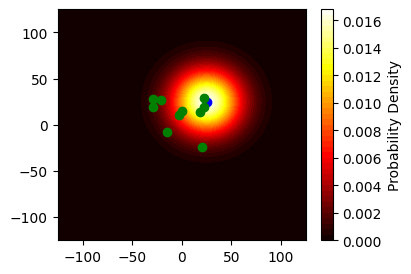

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        5 | -4.424707E+02 | -4.733776E+02
     2 |       10 | -4.558883E+02 | -4.761494E+02
     3 |       15 | -4.689102E+02 | -4.761494E+02
     4 |       20 | -4.738611E+02 | -4.809108E+02
     5 |       25 | -4.745194E+02 | -4.809108E+02
     6 |       30 | -4.781285E+02 | -4.816054E+02
     7 |       35 | -4.803154E+02 | -4.829316E+02
     8 |       40 | -4.823713E+02 | -4.830172E+02
     9 |       45 | -4.841257E+02 | -4.907277E+02
    10 |       50 | -4.843565E+02 | -4.907277E+02
New Position: 
[[ -6.5802676    1.73342104  35.        ]
 [-17.04019567   3.36705011  35.        ]
 [ -3.98690948  35.58933618  35.        ]
 [ -5.26514955  14.2065675   35.        ]
 [ -8.2601848   20.08971298  35.        ]
 [ -3.06531954  -1.42129716  35.        ]
 [ -2.88078972  -0.59662269  35.        ]
 [  7.19702006  -5.04989368  35.        ]
 [ 24.16463665   1.44157516  35.        ]
 [ 20.33988799  31.10199173  35.        ]]

Visibility Gr

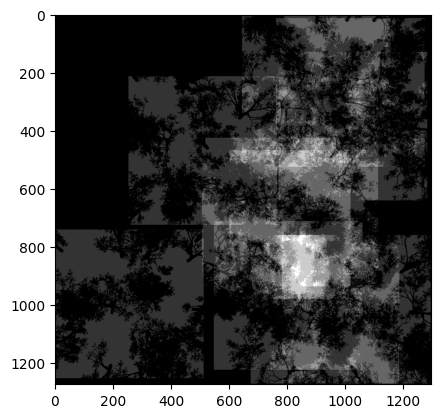

Scoring Grid of Best solution: 




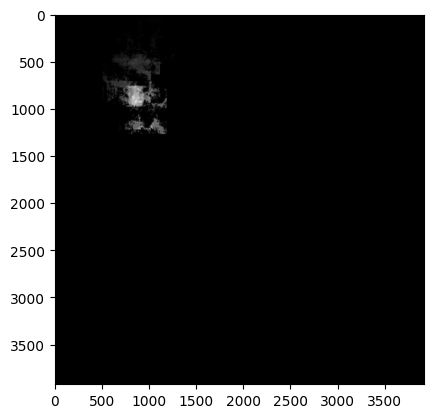

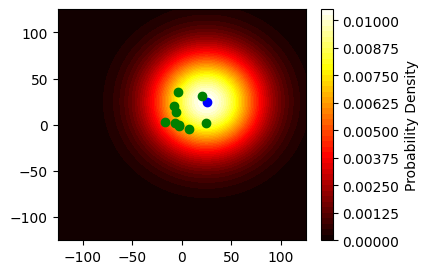

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        5 | -5.438716E+02 | -5.551788E+02
     2 |       10 | -5.500939E+02 | -5.569463E+02
     3 |       15 | -5.553953E+02 | -5.572939E+02
     4 |       20 | -5.565330E+02 | -5.581465E+02
     5 |       25 | -5.604882E+02 | -5.662082E+02
     6 |       30 | -5.637332E+02 | -5.725345E+02
     7 |       35 | -5.649231E+02 | -5.725345E+02
     8 |       40 | -5.676841E+02 | -5.725345E+02
     9 |       45 | -5.677751E+02 | -5.725345E+02
    10 |       50 | -5.704063E+02 | -5.727675E+02
New Position: 
[[ 20.54500002  -1.68566313  35.        ]
 [ 10.62861049 -23.69071394  35.        ]
 [-31.66039928  15.05204371  35.        ]
 [ 19.91142735   4.48492647  35.        ]
 [ 18.30386239  -4.96041834  35.        ]
 [  2.86882046 -29.39471912  35.        ]
 [-32.87263652  14.04592883  35.        ]
 [ 36.01726438  24.04432331  35.        ]
 [ 20.50101583 -21.92353903  35.        ]
 [  9.03021698   7.47472622  35.        ]]

Visibility Gr

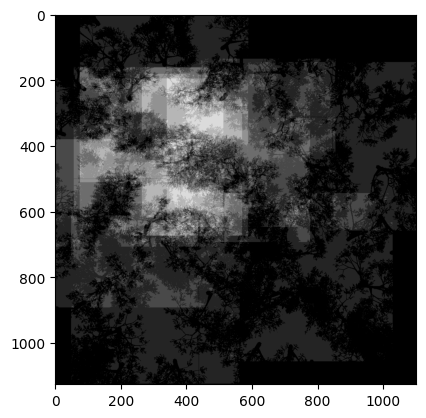

Scoring Grid of Best solution: 




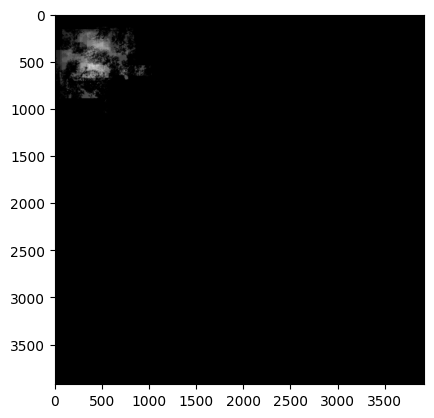

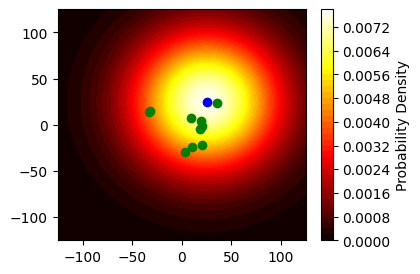

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        5 | -4.243782E+02 | -4.556178E+02
     2 |       10 | -4.345569E+02 | -4.556178E+02
     3 |       15 | -4.391465E+02 | -4.556178E+02
     4 |       20 | -4.476277E+02 | -4.625502E+02
     5 |       25 | -4.527946E+02 | -4.625502E+02


In [ ]:
finished=False
#Drone waypoints got from -25 to 25, Array from 0 to 50
#waypoints=np.array([[-5,0,35.],[-2,0,35.],[ 0,0,35.],[ 2,0,35.],[5,15,35.]])
#swarm.waypoints(ids,waypoints)

visibility_grid= "Null"
runNumber=0

#print(f"Starting with waypoints: \n {waypoints}")

sigma=10

print(f"Starting now, at {time.time() - start}")

dronePath= []
#dronePath = np.array([])
targetDetections = []

while runNumber<maxRuns:
    if  time.time()-start> 72000 or finished:
        print("Time limit reached, stopping")
        break
        
    #print(f"Starting Run number {runNumber} at time: {time.time() - start} ")
    #print(f"Swarm is currently at\n {problem.waypoints}")
    runNumber+=1

    #get best solution
    #try:
    res = minimize(problem, algorithm, termination, seed=1, verbose=True)
    #except Exception as e:
    #    print(f"Minimization had an Exception: {e}")
    _x= np.array(res.X)*(DRONE_STEPSIZE*2)-DRONE_STEPSIZE
    best_solution = _x.reshape(-1, 2)
    
    #update waypoints
    waypoints = waypoints + np.pad(best_solution,((0, 0), (0, 1)),mode='constant',constant_values=0)
    print(f"New Position: \n{waypoints}\n")
    dronePath.append(np.array([waypoints]))
    problem.waypoints = waypoints
                     
    sigma+=TARGET_STEPSIZE
    
    #if target was seen:
    best = res.opt[0]
    best_aux = best.get("aux1")
    best_F = best.get("F")
    #print(f"Score: {best_F} and aux: {best_aux} test")
    #print(f"Waypoints: {waypoints}")
    if best_aux:
        print("Target Seen!\nUpdating target Position and resetting Sigma")
        sigma = 14
        Last_Known_Position= Target_Position
        
        targetDetections.append([runNumber, 0])
    
    #Print the visibiliy Grid, only for debugging purposes
    best_vis = best.get("aux2")
    print(f"Visibility Grid of Best solution: \n\n")
    plt.imshow(best_vis, cmap='gray')
    plt.show()
    best_scor = best.get("aux3")
    print(f"Scoring Grid of Best solution: \n\n")
    plt.imshow(best_scor, cmap='gray')
    plt.show()

    prob_density,x,y = getProbabilityGrid(Last_Known_Position,sigma)
    problem.prob_density = prob_density


    plt.figure(figsize=(4, 3))
    plt.contourf(x, y, prob_density, levels=50, cmap='hot')
    plt.colorbar(label='Probability Density')
    plt.scatter(Last_Known_Position[0],Last_Known_Position[1], color='blue', label='Last Known Position')
    plt.scatter(waypoints[:, 0],waypoints[:, 1], color='green', label='Drones')
    plt.show()
    
    print(f"the average evaluation time per generation was {np.mean(evalTimings)} seconds")
    print(f"the average waypointTimings was {np.mean(waypointTimings)} seconds")
    print(f"the average overlapTimings per Solution Individual was {np.mean(overlapTimings)} seconds")
    print(f"the average scoringTimings per Solution Individual was {np.mean(scoringTimings)} seconds")

print(f"Drone Path:\n{dronePath}\n\n\n\n")
try:
    print(f"\n\nTarget was first detected in Step {targetDetections[0]}")
    print(f"Afterwards target was detected in {np.mean(targetDetections)}% of the following timesteps")
    print("\n\n\n")
except:
    print("Error")
print(f"the average evaluation time per generation was {np.mean(evalTimings)} seconds")
print(f"the average waypointTimings was {np.mean(waypointTimings)} seconds")
print(f"the average overlapTimings per Solution Individual was {np.mean(overlapTimings)} seconds")
print(f"the average scoringTimings per Solution Individual was {np.mean(scoringTimings)} seconds")

print(f"Total Time for {maxRuns} timestep was {time.time()-start} seconds")

In [ ]:
#Kill the Simulation
import os
import signal
run(['pkill', '--full', 'gz sim server'])
print("gz sim server killed")
run(['pkill', '--full', 'gz sim gui'])
print("gz sim gui killed")
process.kill()
print("gz sim killed")
#print(process.communicate())